In [1]:
import numpy as np
import pickle
import keras
from keras import layers , activations , models , preprocessing
from keras import preprocessing , utils
import re
import os
import matplotlib.pyplot as plt
from collections import defaultdict

Using TensorFlow backend.
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

# Workers

In [2]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def __init__(self, mimic, saveFile, saveEpoch):
        super(LossAndErrorPrintingCallback, self).__init__()
        self.mimic = mimic
        self.saveFile = saveFile
        self.saveEpoch =  saveEpoch
        
    def on_epoch_end(self, epoch, logs=None):
        self.mimic.accuracy = logs['accuracy']
        if epoch%self.saveEpoch==0:
            print('Saving model at {}'.format(self.saveFile))
            self.mimic.save(self.saveFile)
            
    def on_train_end(self, logs={}):
        print("Training sucessfull!! Saving model at {}".format(self.saveFile))
        self.mimic.save(self.saveFile)
        
class Mimic:
    UNK = '<UNK>'
    START = '<START>'
    END = '<END>'
    
    def __init__(self, preProcessor, model=None, tokenizer=None, embeddingDim=200, metadata=None,):
        self.model = None
        self.maxInputLen = 0
        self.maxOutputLen = 0
        self.encoder = None
        self.decoder = None
        self.embeddingDim = embeddingDim
        self.preProcessor = preProcessor
        self.accuracy = -1
        if model!=None and tokenizer!=None and metadata!=None:
            self.model = model
            self.tokenizer = tokenizer
            self.vocabSize = len( self.tokenizer.word_index )+1
            self.maxInputLen = metadata['maxInputLen']
            self.maxOutputLen = metadata['maxOutputLen']
            self.embeddingDim = metadata['embeddingDim']
            self.accuracy = metadata['accuracy']
            self.extractChatbot()
    
    def extractEmbeddings(self, word2vecFile):
        print("Using {} for embedding weights".format(word2vecFile))
        embeddings = defaultdict(list,pickle.load(open(word2vecFile,'rb')))
        embeddingDim = len(list(embeddings.values())[0])
        mn = min([j for i in embeddings.values() for j in i])
        mx = max([j for i in embeddings.values() for j in i])
        embeddingMatrix = np.random.uniform(low=mn,high=mx,size=(self.vocabSize, embeddingDim))
        for word,index in self.tokenizer.word_index.items():
            if len(embeddings[word])>0:
                embeddingMatrix[index] = embeddings[word]
        return embeddingMatrix
        
        
    def build(self, inputs, outputs, word2vecFile=None):
        processedInputs = self.preProcessor.cleanTexts(inputs)
        processedOutputs = self.preProcessor.cleanTexts(outputs, tokens=[self.START, self.END])
        
        self.tokenizer = preprocessing.text.Tokenizer(filters='\t\n', oov_token=self.UNK, lower=self.preProcessor.toLower)
        self.tokenizer.fit_on_texts(processedInputs + processedOutputs)
        self.vocabSize = len( self.tokenizer.word_index )+1
        print( 'Vocabulary size from corpus: {}'.format( self.vocabSize ))
        
        encoderInputs = keras.layers.Input(shape=( None , ))
        decoderInputs = keras.layers.Input(shape=( None , ))
        
        if word2vecFile==None:
            encoderEmbedding = keras.layers.Embedding(self.vocabSize, self.embeddingDim , mask_zero=True ) (encoderInputs)
            decoderEmbedding = keras.layers.Embedding( self.vocabSize, self.embeddingDim , mask_zero=True) (decoderInputs)
        else:
            embeddingMatrix = self.extractEmbeddings(word2vecFile)
            self.embeddingDim = len(embeddingMatrix[0])
            encoderEmbedding = keras.layers.Embedding(self.vocabSize, self.embeddingDim , 
                                                      mask_zero=True, weights=[embeddingMatrix]) (encoderInputs)
            decoderEmbedding = keras.layers.Embedding( self.vocabSize, self.embeddingDim , 
                                                      mask_zero=True, weights=[embeddingMatrix]) (decoderInputs)
            
        
        _ , state_h , state_c = keras.layers.LSTM( self.embeddingDim , return_state=True )( encoderEmbedding )
        encoderStates = [ state_h , state_c ]

        decoderLstm = keras.layers.LSTM( self.embeddingDim , return_state=True , return_sequences=True )
        decoderOutputs , _ , _ = decoderLstm ( decoderEmbedding , initial_state=encoderStates )
        
        decoderDense = keras.layers.Dense( self.vocabSize , activation=keras.activations.softmax ) 
        output = decoderDense ( decoderOutputs )

        self.model = keras.models.Model([encoderInputs, decoderInputs], output )
        self.model.compile(optimizer=keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics = ['accuracy'])
        self.extractChatbot()
        print(self.model.summary())
        return processedInputs, processedOutputs
    
    def getOneHot(self, tokenizedText):
        paddedText = np.zeros((tokenizedText.shape[0],tokenizedText.shape[1]))
        for i in range(len(tokenizedText)) :
            paddedText[i] = np.hstack((tokenizedText[i][1:],[0]))
        onehotText = utils.to_categorical( paddedText , self.vocabSize )
        return np.array( onehotText )
    
    def dataGen(self, tokenizedInputs, tokenizedOutputs, batchSize=10):
        paddedInputs = preprocessing.sequence.pad_sequences( tokenizedInputs , maxlen=self.maxInputLen , padding='pre' )
        encoderInput = np.array( paddedInputs )

        paddedAnswers = preprocessing.sequence.pad_sequences( tokenizedOutputs , maxlen=self.maxOutputLen , padding='post' )
        decoderInput = np.array( paddedAnswers )

        totalBatches = len(encoderInput)/batchSize
        counter=0
        while(True):
            prev = batchSize*counter
            nxt = batchSize*(counter+1)
            counter+=1
            decoderOutput = self.getOneHot(decoderInput[prev:nxt])
            yield [encoderInput[prev:nxt], decoderInput[prev:nxt]], decoderOutput
            if counter>=totalBatches:
                counter=0
    
    def fit(self, inputs, outputs, batchSize = 10, epochs = 20, saveFile=None, plot=False, saveEpoch=1):
        tokenizedInputs = self.tokenizer.texts_to_sequences( inputs )
        mx = max( [ len(x) for x in tokenizedInputs ] )
        if mx>self.maxInputLen:
            self.maxInputLen = mx
        
        tokenizedOutputs = self.tokenizer.texts_to_sequences( outputs )
        mx = max( [ len(x) for x in tokenizedOutputs ] )
        if mx>self.maxOutputLen:
            self.maxOutputLen = mx
        if saveFile:
            callBack = [LossAndErrorPrintingCallback(self, saveFile, saveEpoch)]
        else:
            callBack = []
        
        evalutaion = self.model.fit_generator(self.dataGen(tokenizedInputs, tokenizedOutputs, batchSize=batchSize), 
                                              epochs=epochs, steps_per_epoch = len(tokenizedInputs)/batchSize, 
                                              callbacks=callBack)
        self.accuracy = evalutaion.history['accuracy'][-1]
            
        if plot:
            plt.plot(evalutaion.history['accuracy'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epochs')
            plt.show()
            
            plt.plot(evalutaion.history['loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.show()
    
    def extractChatbot(self):
        _, stateH, stateC = self.model.layers[4](self.model.layers[2](self.model.inputs[0]))
        self.encoder = keras.models.Model(self.model.inputs[0], [stateH, stateC])

        inputH = keras.layers.Input(shape=(self.embeddingDim,), name='inpH')
        inputC = keras.layers.Input(shape=(self.embeddingDim,), name='inpC')


        decoderOut, stateH2, stateC2 = self.model.layers[5](self.model.layers[3](self.model.inputs[-1]), 
                                                       initial_state=[inputH, inputC])

        self.decoder = keras.models.Model([self.model.inputs[-1]] + [inputH, inputC], 
                                   [self.model.layers[-1](decoderOut)] + [stateH2, stateC2])

    
    def chat(self, sentence):
        sentence = self. preProcessor.cleanTexts([sentence])[0]
        padSentence = preprocessing.sequence.pad_sequences([self.tokenizer.texts_to_sequences([sentence])[0]] , 
                                                           maxlen=self.maxInputLen , padding='pre')
        print([self.tokenizer.index_word[j] for j in padSentence[0] if j!=0])
        statesValues = self.encoder.predict(padSentence)
        inpTargetSeq = np.zeros( ( 1 , 1 ) )
        inpTargetSeq[0, 0] = self.tokenizer.word_index[self.START]
        reply = ''
        while (1):
            decOut , h , c = self.decoder.predict([ inpTargetSeq ] + statesValues )
            predIndex = np.argmax(decOut[0][0])
            predWord = self.tokenizer.index_word[predIndex]

            if predWord == self.END or len(reply.split()) > self.maxOutputLen:
                break
                
            reply += ' {}'.format(predWord)
            inpTargetSeq[ 0 , 0 ] = predIndex
            statesValues = [ h , c ] 
        return reply
        
    def save(self, saveFile):
        if self.accuracy==-1:
            print("Cannot save untrained model!!!")
        else:
            if not os.path.isdir(saveFile):
                os.makedirs(saveFile)
            self.model.save(saveFile+'\\model.h5')
            metaData = {
                        'maxInputLen':self.maxInputLen,
                        'maxOutputLen':self.maxOutputLen,
                        'preProcessor':self.preProcessor,
                        'embeddingDim':self.embeddingDim,
                        'accuracy':self.accuracy
                       }
            pickle.dump(metaData, open(saveFile+'\\metaData.pkl', 'wb'))
            pickle.dump(self.tokenizer, open(saveFile+'\\tokenizer.pkl', 'wb'))
    
    @classmethod
    def load(cls, loadFile):
        model = keras.models.load_model(loadFile+'\\model.h5')
        metaData = pickle.load(open(loadFile+'\\metaData.pkl', 'rb'))
        tokenizer = pickle.load(open(loadFile+'\\tokenizer.pkl', 'rb'))
        return cls(preProcessor= metaData['preProcessor'], model=model, tokenizer=tokenizer, metadata=metaData)

class Preprocessor:
    def __init__(self, lower=False, keepPunct='[.,!?;]'):
        self.toLower = lower
        self.keepPunct = keepPunct
    
    def cleanTexts(self, textList, tokens=None):
        cleanText = []
        for sent in textList:
            sent = re.sub('[0-9]','',sent)
            if self.toLower:
                sent = sent.lower()
            words = re.findall(r"[\w]+|"+self.keepPunct, sent)
            if tokens:
                words = [tokens[0]]+words+[tokens[1]]
            cleanText.append(' '.join(words))
        return cleanText    

# Training

In [3]:
person = 'monica'
genericQuestions = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\genericQuestionsTrain.pkl'.format(person), 'rb'))
genericAnswers = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\genericAnswersTrain.pkl'.format(person), 'rb'))
personInput = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\{}InputTrain.pkl'.format(person,person), 'rb'))         
personOutput = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\{}OutputTrain.pkl'.format(person,person), 'rb'))
print(personInput[0:3])
print(personOutput[0:3])
print(len(personInput),len(personOutput))

['', 'You know, Id love to, but Im a little tired.', 'Hey!']
['Oh, the way you crushed Mike at ping pong was such a turn-on.You wanna...?', 'Ill put a pillowcase over my head.', 'Whats up?']
6335 6335


Vocabulary size from corpus: 8669
Using C:\Users\Nirvan S P Theethira\Desktop\MiMic\data\monicaData\word2vec.pkl for embedding weights
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    2600700     input_1[0][0]                    
___________________________________________________________________________________

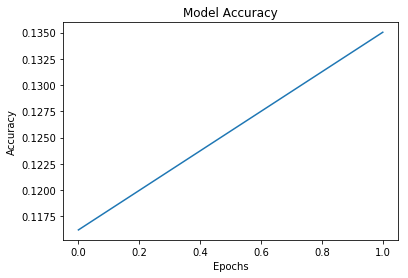

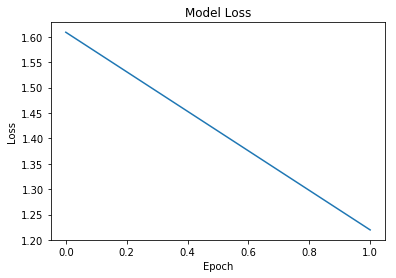

In [4]:
mic = Mimic(Preprocessor())
preQ, preA= mic.build(genericQuestions + personInput, genericAnswers + personOutput,
                       word2vecFile='C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\word2vec.pkl'.format(person))
e = mic.fit(preQ[0:100],preA[0:100],batchSize=10,epochs=2,plot=True,
            saveFile='C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\models\\testSave',
            saveEpoch=1)

# Testing

In [3]:
mic = Mimic.load('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\models\\joey400')
mic.accuracy

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0.990067263709335

In [4]:
person = 'joey'
genericQuestions = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\genericQuestionsTest.pkl'.format(person), 'rb'))
genericAnswers = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\genericAnswersTest.pkl'.format(person), 'rb'))
personInput = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\{}InputTest.pkl'.format(person,person), 'rb'))
personOutput = pickle.load(
    open('C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\{}Data\\{}OutputTest.pkl'.format(person,person), 'rb'))

In [21]:
for i in range(10):
    print(mic.chat(personInput[i]))

['Joey', ',', 'Im', 'not', 'worried', 'about', 'her', '!', 'Im', 'worried', 'about', 'my', 'baby', '!', 'Whoever', 'she', 'dates', 'my', 'baby', 'dates', '!', 'Now', 'now', 'where', 'is', 'this', 'actor', 'taking', 'them', '?']
 I dont want to drive with your hot with the hot girl !
['A', '<UNK>', '?', 'My', 'baby', 'is', 'going', 'on', 'a', '<UNK>', '?', 'Do', 'you', 'have', 'any', 'idea', 'how', 'dangerous', 'those', 'are', '?', '!']
 Look , there is not that one ?
['Hey', 'Joey', '.']
 Hey !
['Awww', ',', 'Ill', 'miss', 'you', 'too', 'Pheebs', '.', 'And', 'I', 'will', 'be', 'holding', 'you', ',', 'right', 'here', '.']
 Hey !
['<UNK>', '?']
 Its gonna be
['Well', ',', 'I', 'tell', 'you', 'what', '.', 'Why', 'dont', 'we', 'uh', ',', 'why', 'dont', 'we', 'just', 'stay', 'here', '?', 'Lets', 'not', 'see', 'a', 'movie', ',', 'well', 'just', 'hang', '.']
 Yeah !
['Hey', ',', 'if', 'thats', 'what', 'you', 'want', 'to', 'do', 'Im', 'not', 'gonna', 'say', 'no', '.']
 What ?
['I', 'just', 'I'

In [22]:
mic.chat("How you doing?")

['How', 'you', 'doing', '?']


' Nothing .'